In [1]:
import os

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy.types import Integer, String, Float, DateTime
#import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import plotly.express as px
import pandas as pd
from prophet import Prophet

# Configurações para visualizações
%matplotlib inline
sns.set(style="whitegrid")

/home/lucas/windir/Documentos/Master/TFM/DSMarket/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Caminho para o arquivo de chave da conta de serviço
service_account_path = '../tfm-sa.json'

# Criar objeto de credenciais
credentials = service_account.Credentials.from_service_account_file(service_account_path)

# Configurações do projeto e dataset
project_id = 'perseverance-332400'
dataset_id = 'TFM'
table_id = 'ds_market'
full_table_id = f'{project_id}.{dataset_id}.{table_id}'

# Criar cliente BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [3]:
# Obter o esquema da tabela
table = client.get_table(full_table_id)  # Faz uma chamada API para obter a tabela

# Extrair os nomes das colunas
columns = [schema_field.name for schema_field in table.schema]

# Exibir as colunas
print("Colunas disponíveis na tabela `TFM.ds_market`:")
for column in columns:
    print(f"- {column}")

Colunas disponíveis na tabela `TFM.ds_market`:
- id
- item
- category_x
- department
- store
- store_code
- region
- d
- sales
- yearweek
- date
- event
- category_y
- sell_price


In [4]:
# Definir uma consulta para obter as primeiras 10 linhas da tabela
sample_query = f"""
SELECT item, store, d,sales,date,event
FROM `{full_table_id}`
WHERE EXTRACT(YEAR FROM date) = 2014;
"""

# Definir a função para executar consultas
def executar_consulta(sql, client):
    """
    Executa uma consulta SQL no BigQuery e retorna um DataFrame do Pandas.
    
    Args:
        sql (str): A consulta SQL a ser executada.
        client (bigquery.Client): Cliente do BigQuery.

    Returns:
        pd.DataFrame: Resultado da consulta.
    """
    query_job = client.query(sql)
    return query_job.to_dataframe()

# Executar a consulta
df = executar_consulta(sample_query, client)

# Exibir o DataFrame de amostra
df

/home/lucas/windir/Documentos/Master/TFM/DSMarket/.venv/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,item,store,d,sales,date,event
0,ACCESORIES_1_007,South_End,d_1414,1,2014-12-12 00:00:00+00:00,None
1,ACCESORIES_1_011,South_End,d_1132,0,2014-03-05 00:00:00+00:00,None
2,ACCESORIES_1_015,South_End,d_1286,2,2014-08-06 00:00:00+00:00,None
3,ACCESORIES_1_032,South_End,d_1303,0,2014-08-23 00:00:00+00:00,None
4,ACCESORIES_1_034,South_End,d_1423,0,2014-12-21 00:00:00+00:00,None
...,...,...,...,...,...,...
11132560,HOME_&_GARDEN_2_483,Queen_Village,d_1138,0,2014-03-11 00:00:00+00:00,None
11132561,HOME_&_GARDEN_2_498,Queen_Village,d_1164,0,2014-04-06 00:00:00+00:00,None
11132562,HOME_&_GARDEN_2_508,Queen_Village,d_1075,0,2014-01-07 00:00:00+00:00,None
11132563,HOME_&_GARDEN_2_510,Queen_Village,d_1178,1,2014-04-20 00:00:00+00:00,Easter


In [78]:
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


In [73]:
product_id = 'ACCESORIES_1_001_BOS_1'  # Substitua pelo ID do produto desejado
store_id = 'South_End'  # Substitua pelo código da loja desejada


In [74]:
filtered_df = df[(df['item'] == product_id) & (df['store'] == store_id)]


In [75]:
# Agregar as vendas por semana
filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.tz_localize(None)
filtered_df.set_index('date', inplace=True)

In [76]:
# Agrupando por semana
agg_data = filtered_df.resample('W').agg({'sales': 'sum'}).reset_index()
agg_data.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

In [77]:
events_df = filtered_df[filtered_df['event'].notna()][['date', 'event']].reset_index(drop=True)
events_df['holiday'] = events_df['event']
events_df['ds'] = pd.to_datetime(events_df['date'])

KeyError: "['date'] not in index"

In [ ]:
def get_window(event):
    if event == 'SuperBowl':
        return 0, 1
    elif event == 'Ramadan starts':
        return 0, 1
    elif event == 'NewYear':
        return -1, 1
    elif event == 'Easter':
        return 0, 1
    elif event == 'Thanksgiving':
        return -1, 1
    else:
        return 0, 0  # Valor padrão se o evento não for reconhecido

In [ ]:
# Aplicar a função para definir as janelas
windows = events_df['holiday'].apply(get_window)
events_df['lower_window'], events_df['upper_window'] = zip(*windows)

In [ ]:
events_df = events_df[['ds', 'holiday', 'lower_window', 'upper_window']].drop_duplicates()


In [57]:
model = Prophet(holidays=events_df)
model.fit(agg_data)

In [58]:
# Fazer previsões para o futuro (exemplo: 30 dias)
future = model.make_future_dataframe(periods=30, freq='W')
forecast = model.predict(future)

14:24:30 - cmdstanpy - INFO - Chain [1] start processing
14:24:30 - cmdstanpy - INFO - Chain [1] done processing


            ds      yhat  yhat_lower  yhat_upper
0   2011-02-01  0.017692   -1.414323    1.511809
1   2011-02-05 -0.085903   -1.650326    1.534770
2   2011-02-08  0.238190   -1.217042    1.677952
3   2011-02-13 -0.433772   -1.882760    1.026599
4   2011-02-18  0.435892   -0.984814    1.846564
..         ...       ...         ...         ...
540 2016-05-16  0.238798   -1.190671    1.763030
541 2016-05-17  1.081533   -0.372860    2.575749
542 2016-05-18  0.313346   -1.123957    1.859431
543 2016-05-19  1.240599   -0.286772    2.736407
544 2016-05-20  0.985991   -0.587839    2.477424

[545 rows x 4 columns]


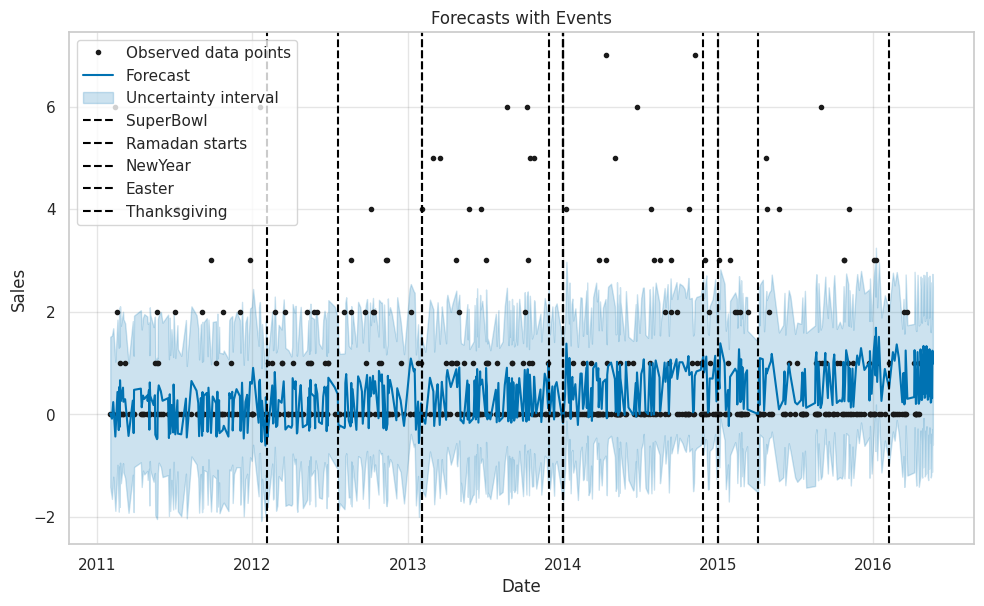

In [65]:
fig = model.plot(forecast)
# Definir cores para diferentes tipos de eventos
event_colors = {
    'SuperBowl': 'red',
    'Ramadan starts': 'purple',
    'NewYear': 'blue',
    'Easter': 'green',
    'Thanksgiving': 'orange',
}

# Adicionar eventos ao gráfico com diferentes cores
for index, row in events_df.iterrows():
    event_type = row['holiday']
    color = event_colors.get(event_type, 'black')  # Cor padrão se não for encontrada
    plt.axvline(x=row['ds'], color=color, linestyle='--', label=event_type if event_type not in plt.gca().get_legend_handles_labels()[1] else "")

# Adicionar legendas e título
plt.title('Previsões Semanais com Eventos')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend(loc='upper left')
plt.show()

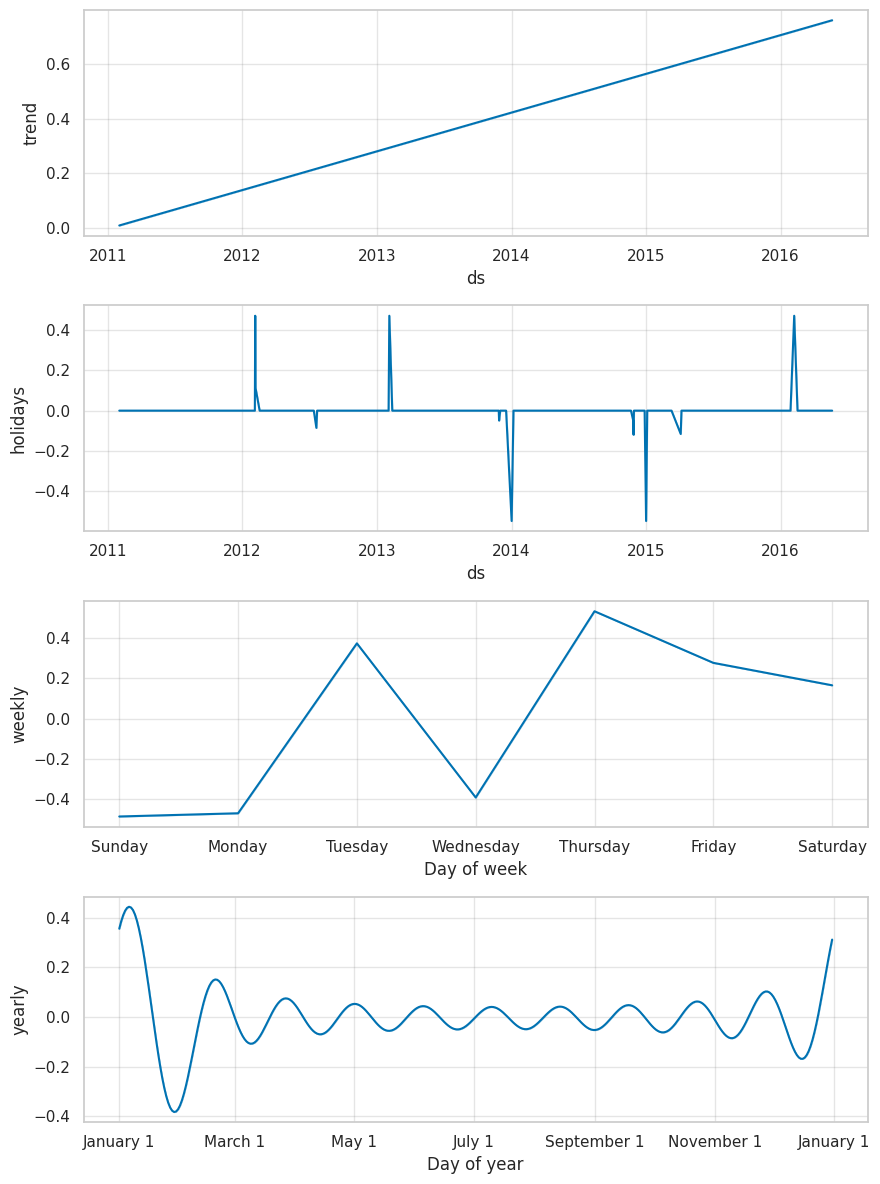

In [60]:
# Visualizar os componentes do modelo
fig2 = model.plot_components(forecast)
